In [7]:
import os 
import sys
import pandas as pd
import configparser
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob as glob
from tqdm import tqdm
from data_utils import *
import re
from pathlib import Path
import h5py

In [23]:
split = 'Testing' # Training or Testing

### Copy the data in one folder

In [28]:
root_dir = f'/home/maxime.difolco/Documents/data/ACDC/ground_truth/'
out_dir = f'/home/maxime.difolco/Documents/data/test/preprocessed_ACDC/'

if split == 'Testing':
    out_dir = out_dir[:-1] + f'_{split}/'.lower()
    root_dir = root_dir[:-1] + f'_{split}/'.lower()
    
if not os.path.exists(out_dir):
    # If not, create the folder
    os.makedirs(out_dir)

list_files_img = np.sort(glob(f'{root_dir}**/*frame0[1,4].nii.gz'))
list_files_gt = np.sort(glob(f'{root_dir}**/*frame0[1,4]_gt.nii.gz'))
print(len(list_files_img))

for path_img, path_gt in tqdm(zip(list_files_img,list_files_gt)):

    case_name = re.search('patient\d\d\d', path_img).group()
    #print(case_name)
    img = sitk.ReadImage(path_img)
    img_gt = sitk.ReadImage(path_gt)

    ed = int(path_img[-8])

    img_ed = get_slice(img, ed)
    img_gt_ed = get_slice(img_gt, ed)

    mask_img_gt = sitk.Mask(img_gt_ed,sitk.Not(img_gt_ed>1),1)

    multiply = sitk.MultiplyImageFilter()
    mask_multiplier = sitk.Cast(mask_img_gt, sitk.sitkFloat64)
    new_img = multiply.Execute(sitk.Cast(img_ed, sitk.sitkFloat64), mask_multiplier)

    r_img = resample_images(new_img, is_label=True)
    r_gt = resample_images(img_gt_ed, is_label = True)

    sitk.WriteImage(r_img, f'{out_dir}{case_name}.nii.gz')
    sitk.WriteImage(r_gt, f'{out_dir}{case_name}_gt.nii.gz')

50


50it [00:03, 15.62it/s]


### Create dataset

In [29]:
dist_dir = f'/home/maxime.difolco/Documents/data/test/preprocessed_ACDC/'
output_file = f'/home/maxime.difolco/Documents/data/test/patch_data/data.h5'
    
if split == 'Testing':
    dist_dir = dist_dir[:-1] + '_testing/'
    path_split =  os.path.split(output_file)
    output_file = path_split[0] + '/testing_' + path_split[1]

print(dist_dir, output_file)
pattern = r'patient\d\d\d'

list_files = np.sort(glob(f'{dist_dir}*[0-9].nii.gz'))
print(len(list_files))

if Path(output_file).exists():
    os.remove(output_file)

with h5py.File(output_file,'w') as ff:
    for fi in list_files:
        pid = re.search(pattern,fi).group()
        data = load_array(fi)
        
        # Load gt
        start = re.search(pattern,fi).start()
        data_gt = load_array(fi[:start] + pid + '_gt.nii.gz')
        slice_num = _get_first_slice(data_gt)
        data = np.squeeze(data[:,:,slice_num])

        data, _ = align_case(data, np.squeeze(data_gt[:,:,slice_num]), labels = {'LV':3, 'Myo':2, 'RV':1})

        ff.create_dataset(f'{pid}', data=data)


/home/maxime.difolco/Documents/data/test/preprocessed_ACDC_testing/ /home/maxime.difolco/Documents/data/test/patch_data/testing_data.h5
50


### Example to access an image

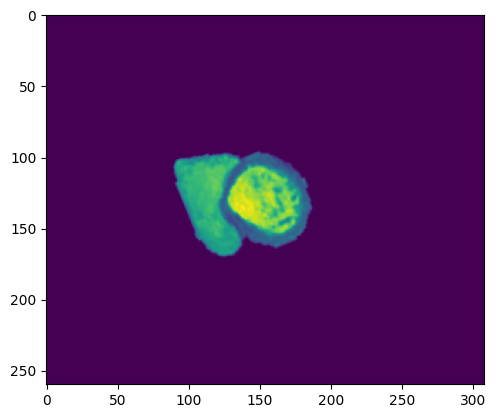

In [31]:
patch_file = "/home/maxime.difolco/Documents/data/test/patch_data/data.h5"
ff =  h5py.File(patch_file, 'r')
K = [k for k in ff.keys()]
d = ff[K[0]][:]
plt.imshow(d)

### Compute attributes